In [3]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import poppy

from adefc_vortex.math_module import xp, xcipy, ensure_np_array
from adefc_vortex import utils
from adefc_vortex.imshows import imshow1, imshow2, imshow3, plot_data
from adefc_vortex import dm
from adefc_vortex import props
from adefc_vortex import aefc_1dm as aefc
import adefc_vortex.pwp as pwp
import adefc_vortex.scoob_model as scoobm
import adefc_vortex.scoob_interface as scoobi

import purepyindi
from purepyindi import INDIClient
import purepyindi2
from purepyindi2 import IndiClient
client0 = INDIClient('localhost', 7624)
client0.start()
client = IndiClient()
client.connect()
client.get_properties()

wavelength_c = 633e-9
npix = 1000


/opt/conda/envs/km310env/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [42]:
scoobi.home_block(client0)

In [43]:
scoobi.move_block_out(client0)

In [203]:
reload(scoobi)
xc, yc = (4600, 3400)
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)

In [4]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', dm_channel='dm00disp05')
I.npsf = 150

# Do the normalization

In [19]:
scoobi.move_psf(-10, 0, client0)

In [15]:
scoobi.move_psf(0, -50, client0)

In [16]:
reload(scoobi)
I.set_zwo_exp_time(0.0005, client0)

Set the ZWO exposure time to 5.00e-04s


In [23]:
reload(scoobi)
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


In [17]:
reload(scoobi)
I.set_fib_atten(37, client)

Set the fiber attenuation to 37.0


56734.98


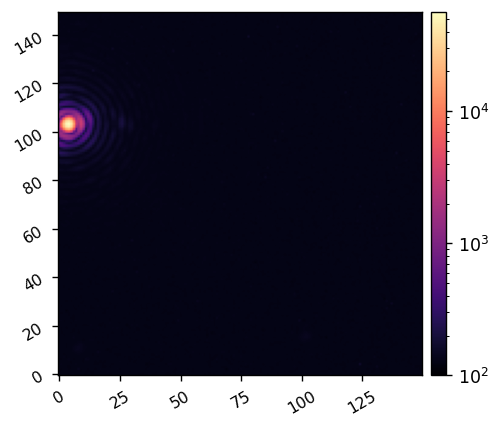

In [29]:
I.NSCICAM = 200
ref_psf = I.snap()
print(xp.max(ref_psf))
imshow1(ref_psf, lognorm=True, vmin=1e2)

In [30]:
I.ref_psf_params = {
    'ref_psf':copy.copy(ref_psf),
    'Imax': copy.copy(xp.max(ref_psf)),
    'texp': copy.copy(I.texp), 
    'atten': copy.copy(I.atten),
    'gain': copy.copy(I.gain),
}
utils.save_pickle(f'data/{today}_ref_psf_params_2.pkl', I.ref_psf_params)

# I.ref_psf_params = utils.load_pickle(f'data/{today}_ref_psf_params.pkl')

Saved data to:  data/20250115_ref_psf_params_2.pkl


In [31]:
print(I.ref_psf_params)

{'ref_psf': array([[129.46, 130.78, 128.36, ..., 129.58, 127.72, 130.5 ],
       [127.8 , 128.22, 128.72, ..., 129.22, 129.4 , 128.76],
       [128.56, 127.56, 129.54, ..., 128.38, 128.98, 125.9 ],
       ...,
       [129.14, 129.  , 130.62, ..., 129.5 , 128.12, 129.24],
       [129.84, 129.44, 131.5 , ..., 127.42, 127.78, 129.  ],
       [127.1 , 130.56, 130.6 , ..., 128.52, 128.88, 128.34]]), 'Imax': array(56734.98), 'texp': 0.0005, 'atten': 37, 'gain': 120}


In [254]:
scoobi.move_psf(-1, 0, client0)


In [189]:
scoobi.move_psf(0, -1, client0)

In [190]:
I.set_fib_atten(20, client)

Set the fiber attenuation to 20.0


In [191]:
I.set_zwo_exp_time(0.1, client0)

Set the ZWO exposure time to 1.00e-01s


In [192]:
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


In [77]:
reload(scoobi)
scoobi.move_block_in(client0)

Saved data to:  data/20250115_camsci_dark_frame_2.pkl


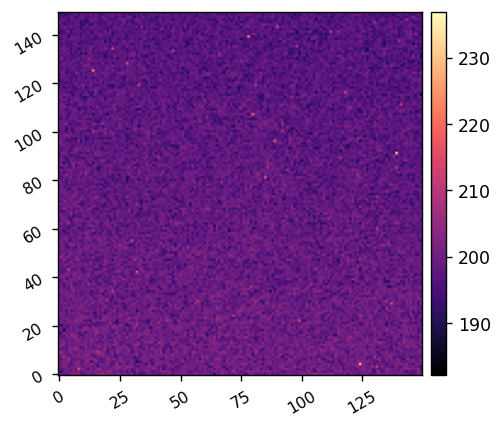

In [78]:
I.NSCICAM = 200
I.subtract_dark = False
I.return_ni = False
dark_frame = I.snap()
utils.save_pickle(f'data/{today}_camsci_dark_frame_2.pkl', dark_frame)
I.df = copy.copy(dark_frame)
imshow1(dark_frame)

# dark_frame = utils.load_pickle(f'data/{today}_camsci_dark_frame.pkl')
# I.df = copy.copy(dark_frame)
# imshow1(dark_frame)

In [79]:
reload(scoobi)
scoobi.move_block_out(client0)

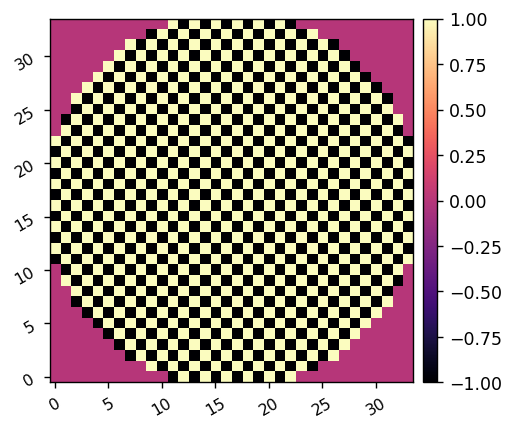

In [133]:
reload(scoobi.utils)
waffle_command = utils.make_fourier_command(x_cpa=17, y_cpa=17) * xp.array(I.dm_mask)
imshow1(waffle_command)

In [256]:
I.set_fib_atten(22, client)

Set the fiber attenuation to 22.0


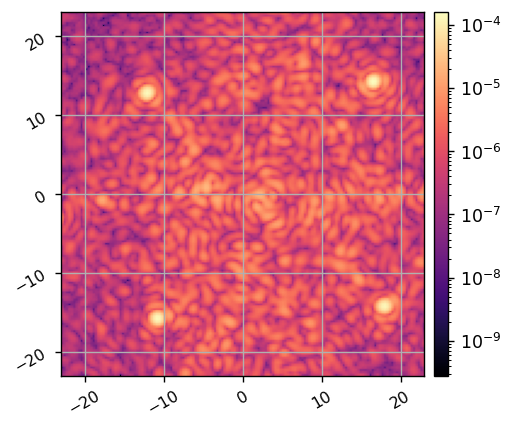

In [257]:
I.set_dm(10e-9 * waffle_command)
I.x_shift = 0
I.y_shift = 0

# original_texp = I.texp
# I.set_zwo_exp_time(0.005, client0)

I.NSCICAM = 10
I.subtract_dark = True
I.return_ni = True
waffle_im = I.snap()
imshow1(
    waffle_im, 
    lognorm=True, 
    # vmin=1e-7, 
    pxscl=I.psf_pixelscale_lamDc, 
    grid=True,
)

# I.set_zwo_exp_time(original_texp, client0)


Centroids:
 [[ 39.40747013  23.32453962]
 [ 35.01208293 116.0533662 ]
 [128.19778386 120.95093918]
 [132.8774527   28.32526747]
 [ 39.40747013  23.32453962]]


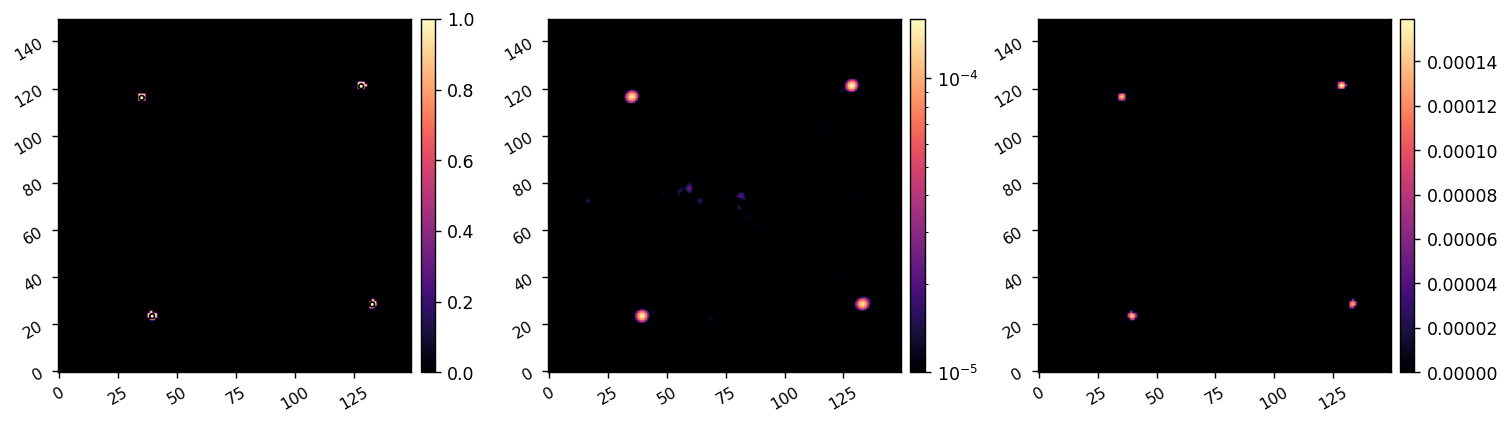

Angle:  87.08073423636604
Measured center in X:  83.89230676279462
Measured center in Y:  72.23634376658275
Required shift in X:  -9.0
Required shift in Y:  3.0


In [258]:
reload(utils)

xshift, yshift, angle = utils.measure_center_and_angle(
    waffle_im, 
    I.psf_pixelscale_lamDc, 
    im_thresh=7e-5, 
    r_thresh=16,
)

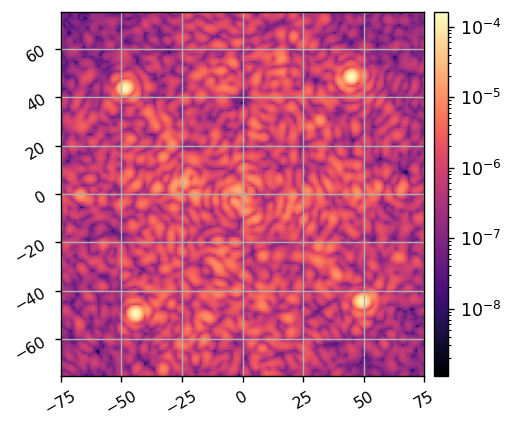

In [259]:
I.NSCICAM = 10
I.npsf = 150
I.x_shift = xshift
I.y_shift = yshift-1

I.subtract_dark = True
I.return_ni = True

waffle_im = I.snap()
imshow1(waffle_im, lognorm=True, pxscl=1, grid=True)

In [260]:
I.set_fib_atten(15, client)

Set the fiber attenuation to 15.0


In [241]:
I.zero_dm()

In [146]:
I.atten, I.gain, I.texp

(15, 120, 0.1)

1.695646572852077e-06


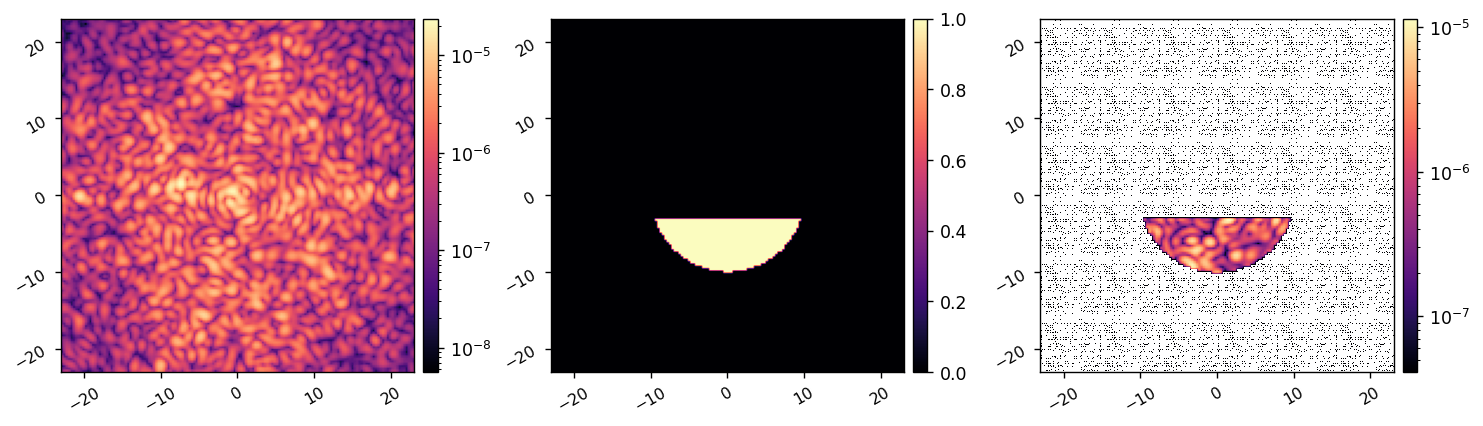

In [261]:
iwa = 3
owa = 10
rotation = 90
control_mask = utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, iwa, owa, edge=iwa, rotation=rotation)

I.zero_dm()
I.NSCICAM = 40
I.subtract_dark = True
I.return_ni = True

ref_coro_im = I.snap()
print(xp.mean(ref_coro_im[control_mask]))
imshow3(ref_coro_im, control_mask, control_mask * ref_coro_im,
        lognorm1=True, lognorm3=True, pxscl=I.psf_pixelscale_lamDc)

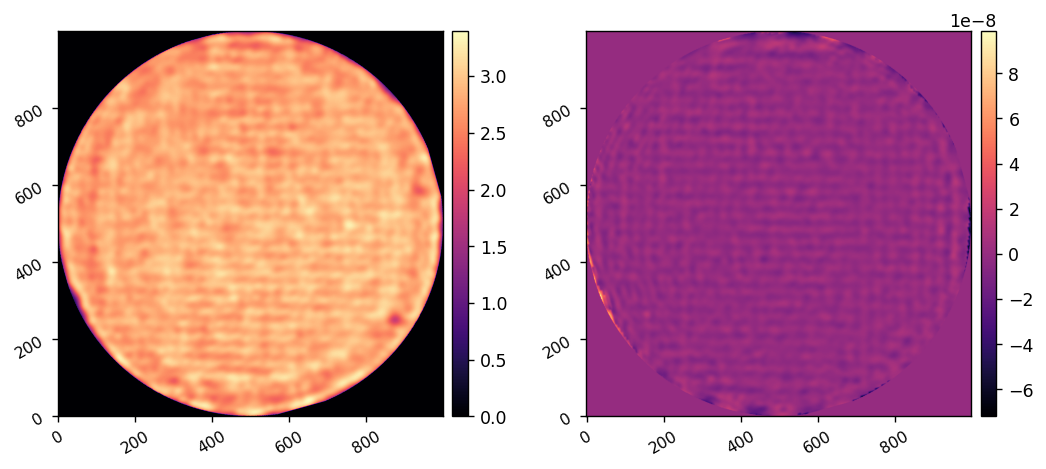

In [262]:
pr_fit = utils.load_pickle(f'data/20250114_fdpr2_ref_processed.pkl')

wfe_amp = pr_fit['amp']
wfe_opd = pr_fit['opd']
imshow2(wfe_amp, wfe_opd)

In [90]:
16/34 * 2 * 10.2

9.6

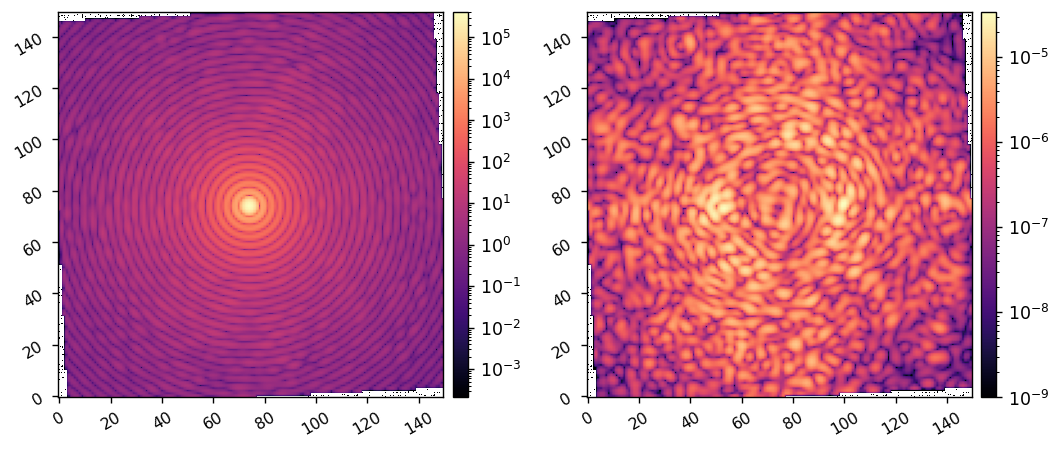

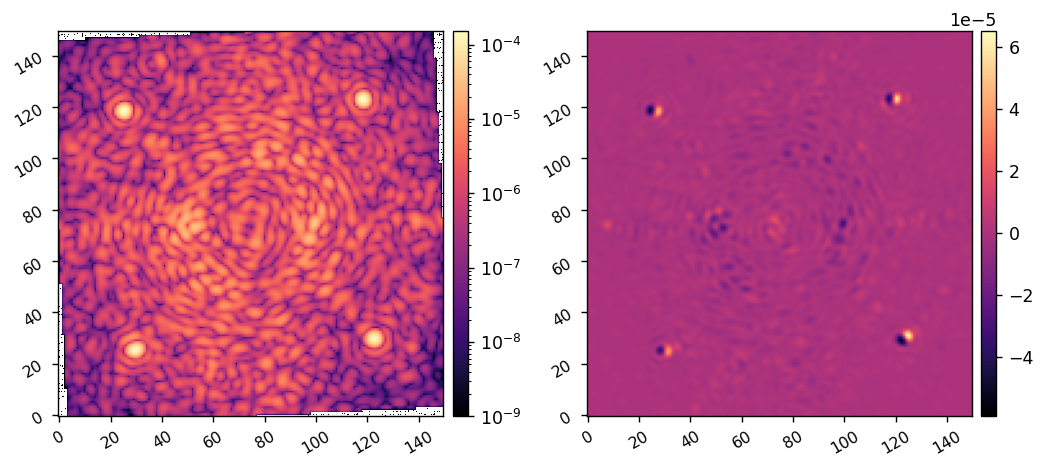

In [321]:
reload(scoobm)
M = scoobm.MODEL(
    # dm_beam_diam=9.4*u.mm, 
    # lyot_pupil_diam=9.4*u.mm,
    # lyot_stop_diam=8.7*u.mm,
    # dm_shift=np.array([0.1,0.0])*u.mm,
    lyot_shift=np.array([0.075, 0.15])*u.mm,
)
M.AMP = wfe_amp
M.OPD = wfe_opd

M.reverse_lyot = 1
M.flip_lyot = 1
M.det_rotation = 177.25

M.setattr('use_vortex', False)
m_ref_psf = M.snap()
M.setattr('Imax_ref', xp.max(m_ref_psf))

M.setattr('use_vortex', True)
m_coro_im = M.snap()

imshow2(
    m_ref_psf, m_coro_im, 
    lognorm=1,
    vmin2=1e-9,
)

M.set_dm(5e-9 * waffle_command)
m_waffle_im = M.snap()
M.zero_dm()

imshow2(
    m_waffle_im, waffle_im-m_waffle_im, 
    lognorm1=True, 
    vmin1=1e-9,
)
# fpwf = M.forward(np.zeros(M.Nacts), use_vortex=True, plot=True)


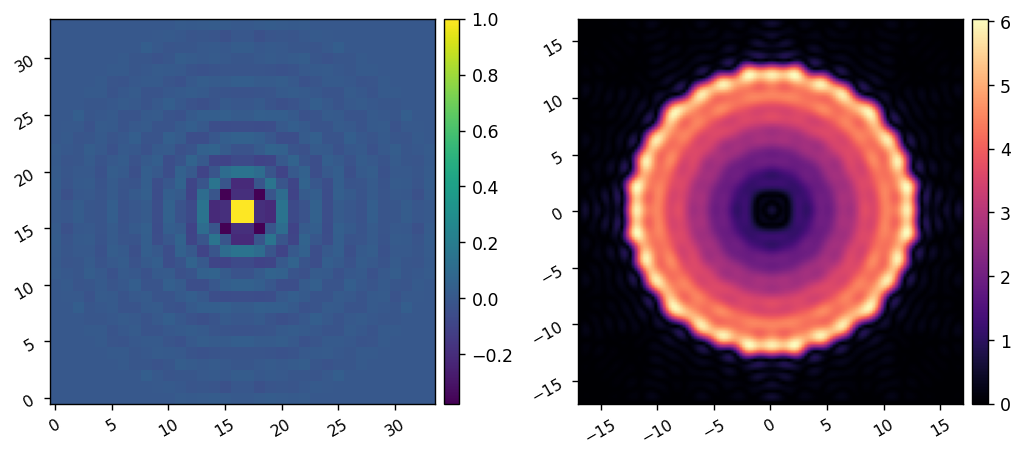

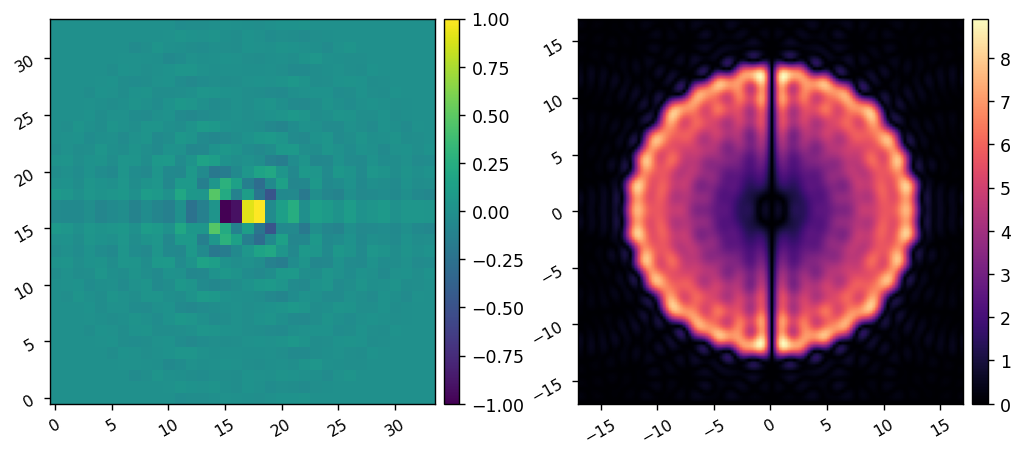

In [322]:
reload(utils)
fourier_probes = utils.create_fourier_probes(
    xp.array(I.dm_mask), 
    I.npsf, 
    I.psf_pixelscale_lamDc, 
    iwa-0.5, owa+2, 
    # edge=iwa-0.5,
    fourier_sampling=0.75, 
    # rotation=90,
    nprobes=2,
    plot=True,
    use_weighting=True
)
fourier_probes[0] = xp.rot90(fourier_probes[0])
fourier_probes[1] = xp.rot90(fourier_probes[1])

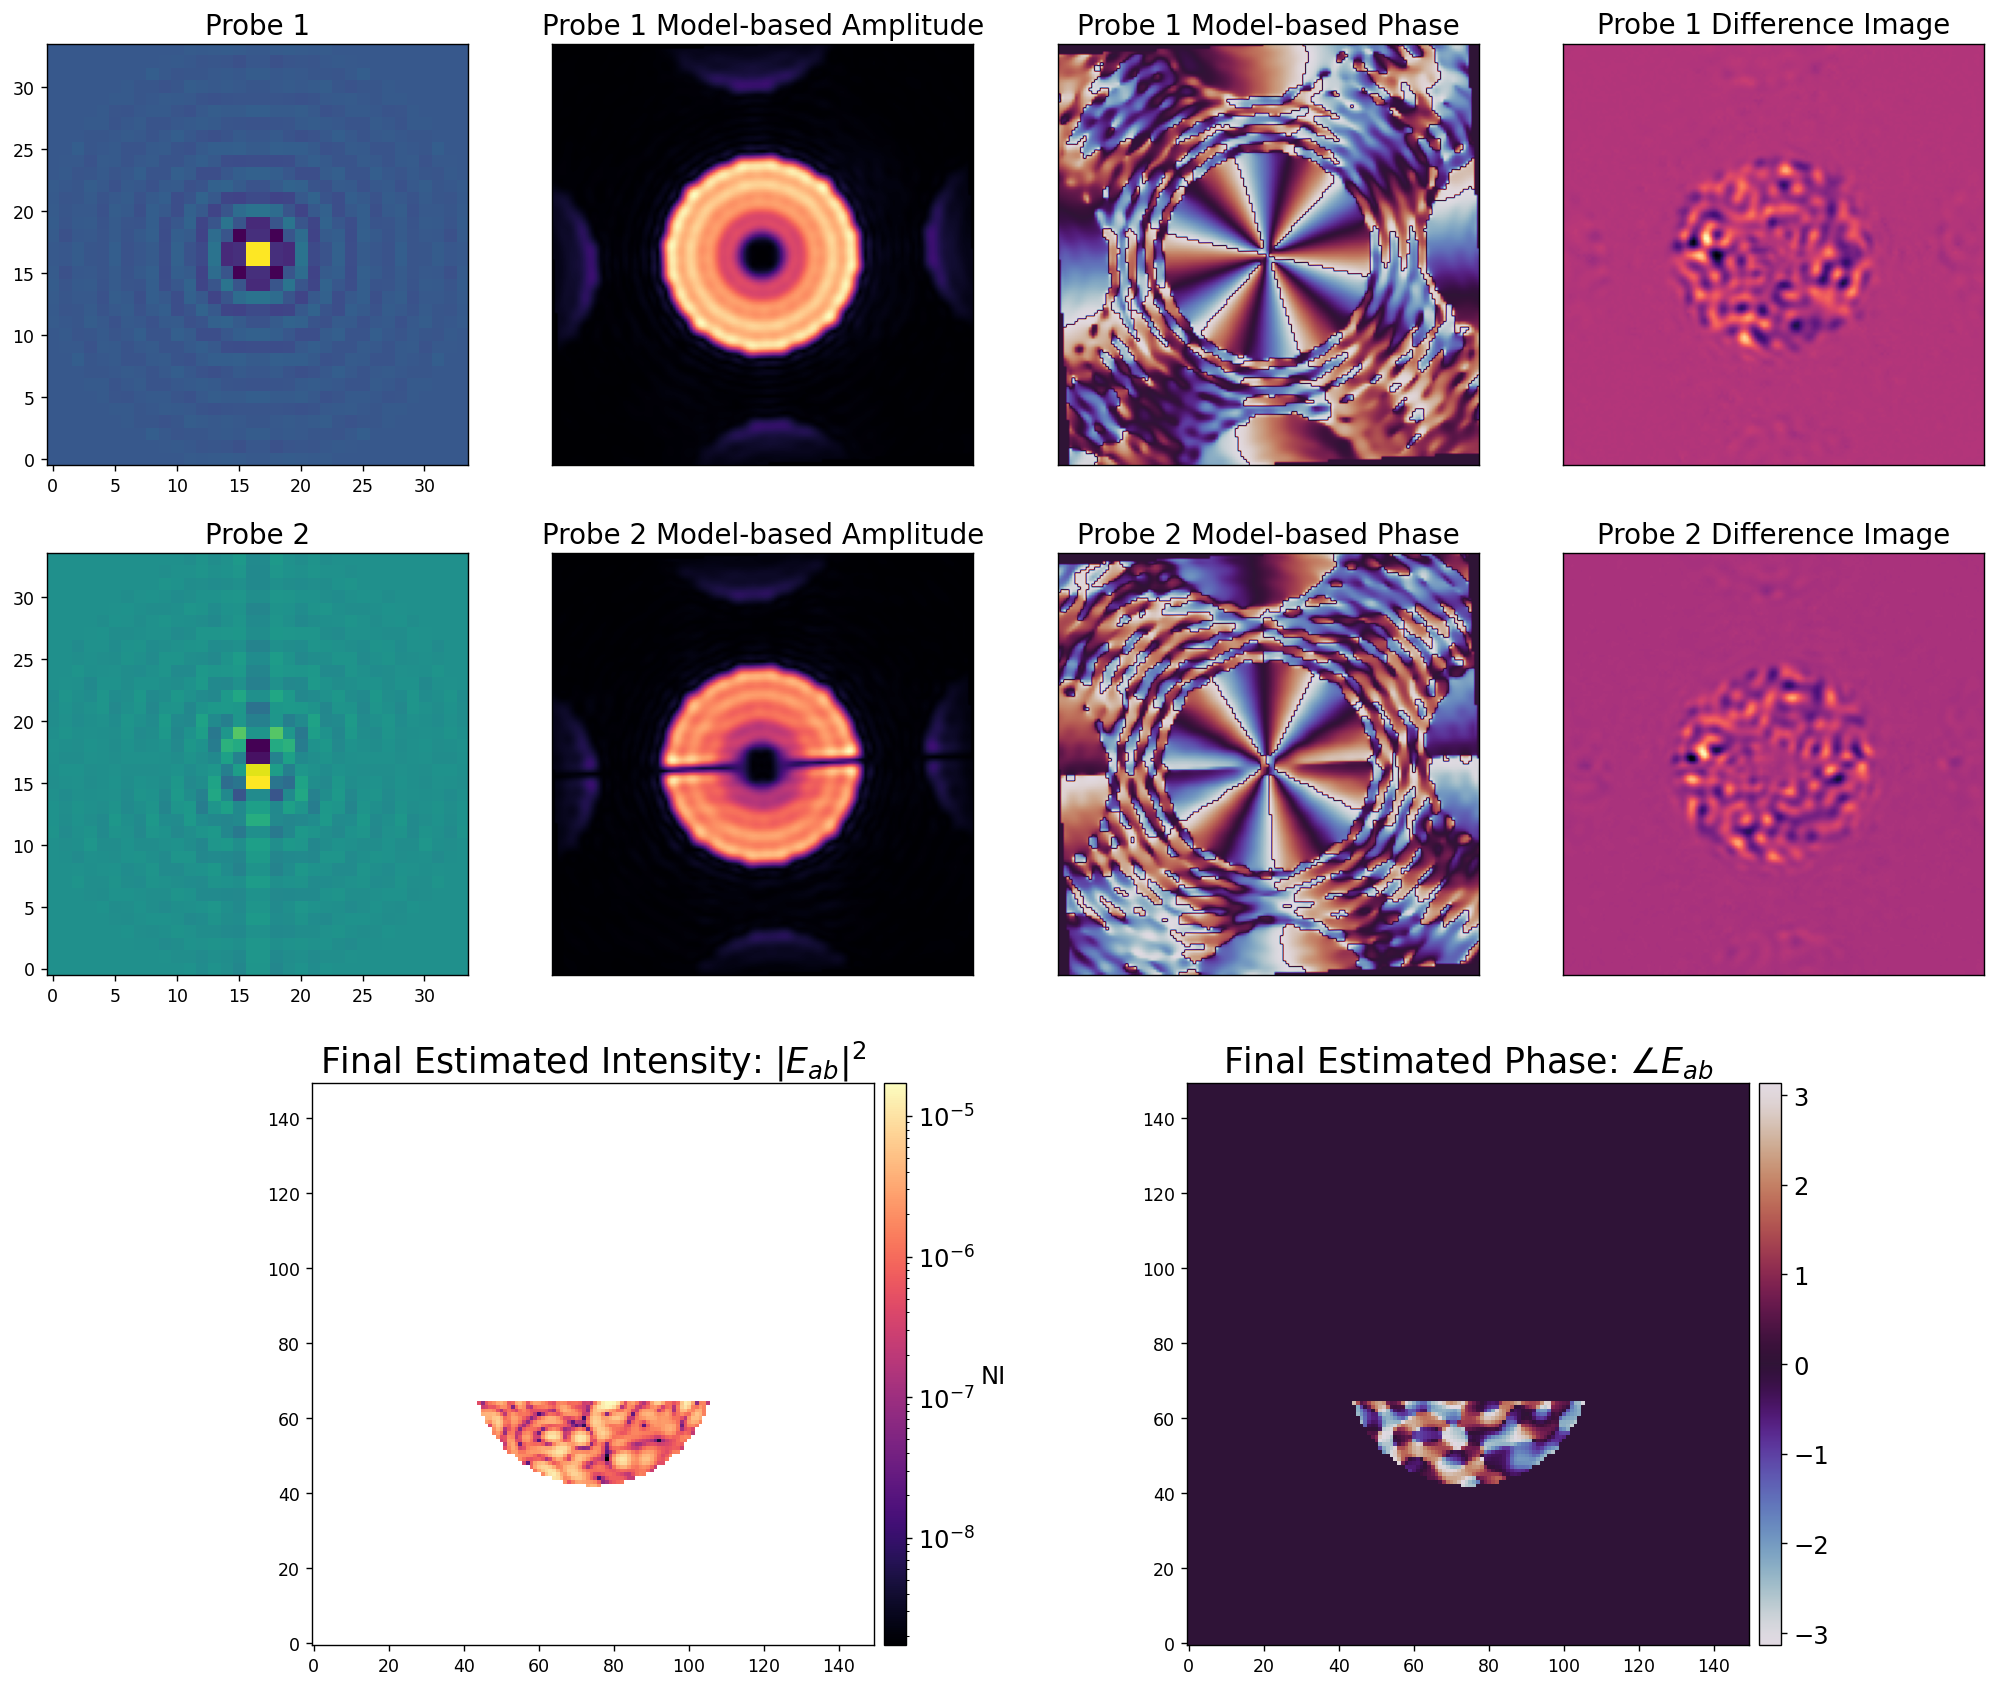

In [208]:
reload(pwp)

acts = xp.zeros(M.Nacts)

I.set_dm(scoobm.acts_to_command(acts, M.dm_mask))
E_pwp = pwp.run(
    I, 
    M, 
    control_mask, 
    fourier_probes, 
    2.5e-9, 
    I.wavelength_c, 
    reg_cond=1e-2, 
    gain=2.5,
    Ndms=1,
    plot=True,
)
I_pwp = xp.abs(E_pwp)**2
P_pwp = xp.angle(E_pwp)

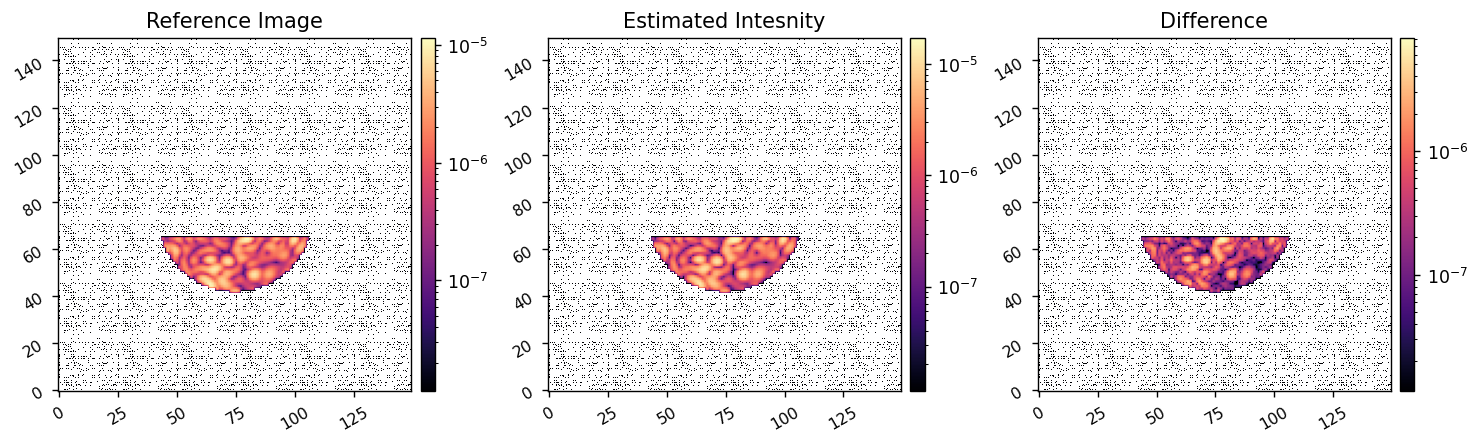

In [323]:
I_diff = ref_coro_im*control_mask - I_pwp
vmin = xp.max(ref_coro_im*control_mask)/1e3
imshow3(
    ref_coro_im*control_mask, I_pwp, xp.abs(I_diff), 
    'Reference Image', 'Estimated Intesnity', 'Difference',
    lognorm1=True, lognorm2=True, 
    vmin1=vmin, vmin2=vmin, 
    lognorm3=True, vmin3=vmin,
)

In [335]:
scoobi.move_psf(-1, 0, client0)

In [298]:
scoobi.move_psf(0, 1, client0)

1.6273148184517746e-06


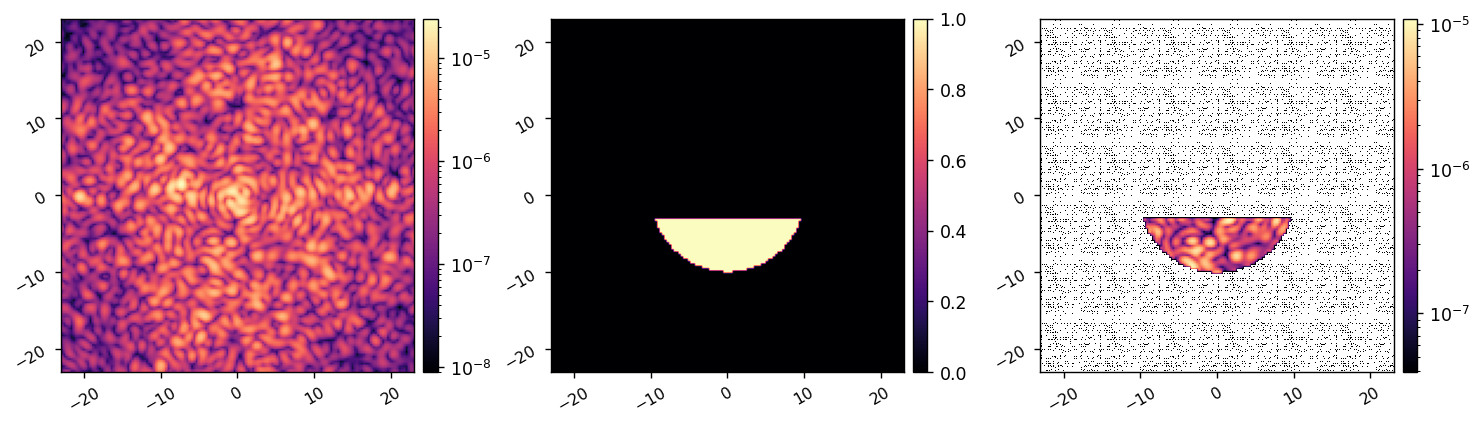

In [337]:
iwa = 3
owa = 10
rotation = 90
control_mask = utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, iwa, owa, edge=iwa, rotation=rotation)

I.zero_dm()
I.NSCICAM = 40
I.subtract_dark = True
I.return_ni = True

ref_coro_im = I.snap()
print(xp.mean(ref_coro_im[control_mask]))
imshow3(ref_coro_im, control_mask, control_mask * ref_coro_im,
        lognorm1=True, lognorm3=True, pxscl=I.psf_pixelscale_lamDc)

In [340]:
I.zero_dm()
data = {
    # 'ref_im':ref_coro_im, 
    'images':[ref_coro_im],
    'efields':[],
    'commands':[],
    'del_commands':[],
    'reg_conds':[],
    'bfgs_tols':[],
    'pixelscale':I.psf_pixelscale_lamDc,
    'control_mask':control_mask, 
}

In [325]:
I.set_fib_atten(15, client)

Set the fiber attenuation to 15.0


Running iteration 13
Running PWP ...


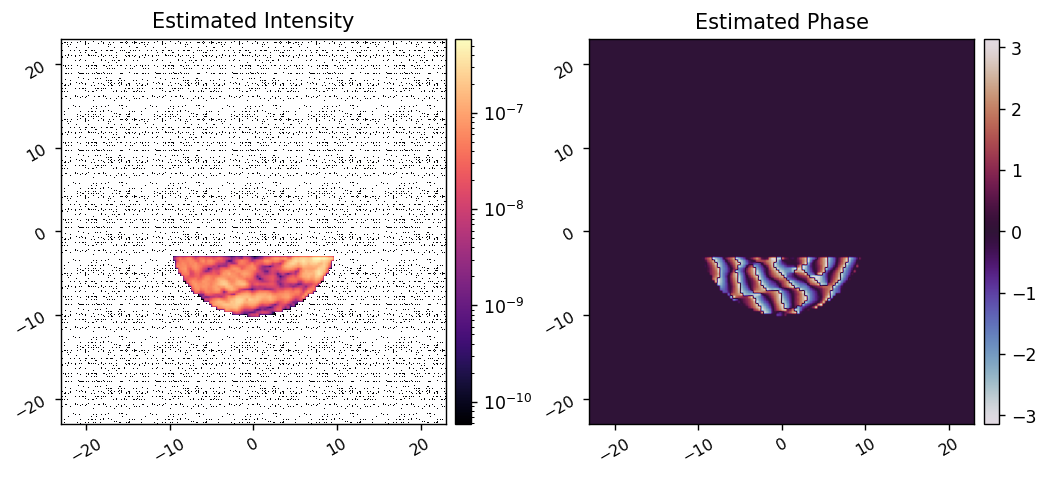

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  1.18600D+08

At iterate    1    f=  4.07013D-01    |proj g|=  5.06686D+07

At iterate    2    f=  2.72890D-01    |proj g|=  2.18542D+07

At iterate    3    f=  2.12999D-01    |proj g|=  1.48410D+07

At iterate    4    f=  1.67297D-01    |proj g|=  1.44271D+07

At iterate    5    f=  1.46232D-01    |proj g|=  1.36170D+07

At iterate    6    f=  1.30714D-01    |proj g|=  6.58424D+06

At iterate    7    f=  1.19431D-01    |proj g|=  4.42529D+06

At iterate    8    f=  1.10580D-01    |proj g|=  5.00791D+06

At iterate    9    f=  1.03953D-01    |proj g|=  1.12621D+07

At iterate   10    f=  9.17165D-02    |proj g|=  3.20465D+06

At iterate   11    f=  8.80565D-02    |proj g|=  2.23994D+06

At iterate   12    f=  8.35824D-02    |proj g|=  2.89737D+06

At iterate   13    f=  8.2

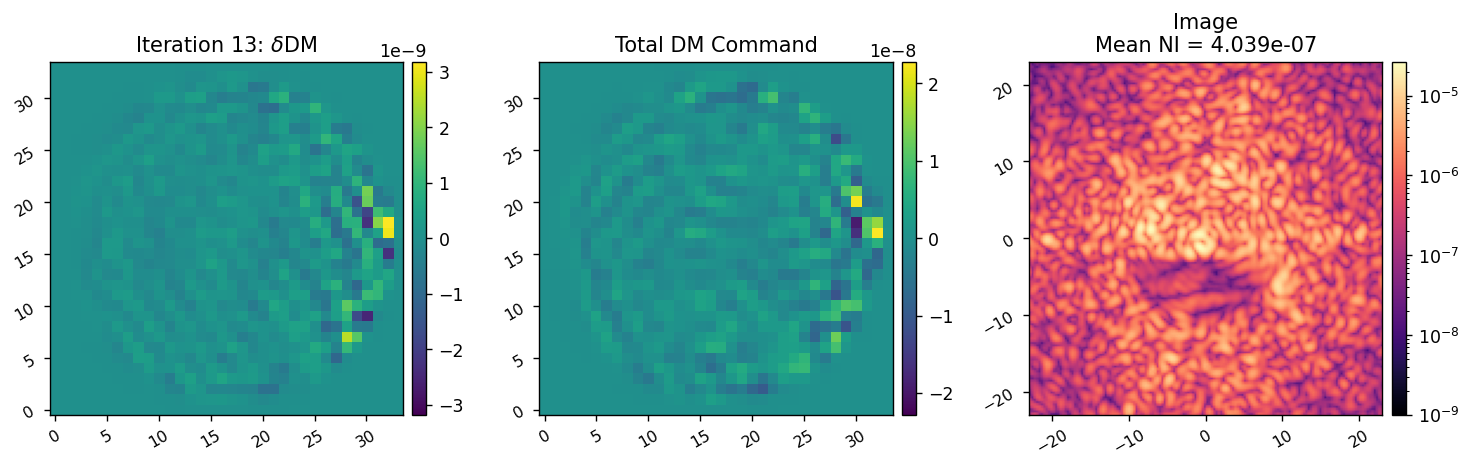

Running iteration 14
Running PWP ...


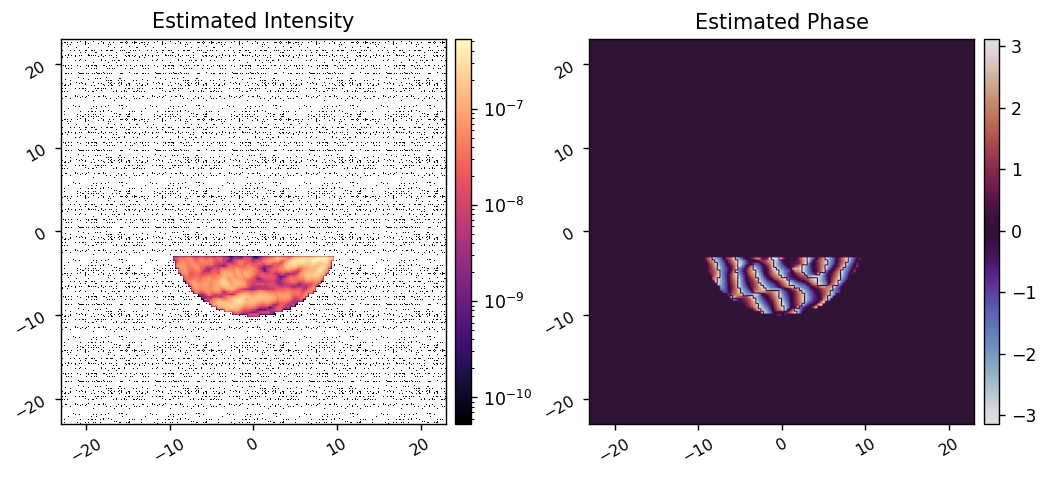

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  1.03878D+08


 This problem is unconstrained.



At iterate    1    f=  4.10122D-01    |proj g|=  4.97508D+07

At iterate    2    f=  2.69913D-01    |proj g|=  2.44753D+07

At iterate    3    f=  2.07444D-01    |proj g|=  1.69870D+07

At iterate    4    f=  1.61009D-01    |proj g|=  1.28202D+07

At iterate    5    f=  1.39466D-01    |proj g|=  1.23204D+07

At iterate    6    f=  1.24166D-01    |proj g|=  6.20241D+06

At iterate    7    f=  1.13399D-01    |proj g|=  4.06068D+06

At iterate    8    f=  1.05113D-01    |proj g|=  4.32657D+06

At iterate    9    f=  9.92031D-02    |proj g|=  1.12543D+07

At iterate   10    f=  8.84366D-02    |proj g|=  2.86797D+06

At iterate   11    f=  8.52180D-02    |proj g|=  2.19774D+06

At iterate   12    f=  8.12632D-02    |proj g|=  2.71046D+06

At iterate   13    f=  7.99894D-02    |proj g|=  7.02803D+06

At iterate   14    f=  7.63084D-02    |proj g|=  2.53667D+06

At iterate   15    f=  7.44821D-02    |proj g|=  1.73959D+06

At iterate   16    f=  7.22571D-02    |proj g|=  2.07620D+06

At iter

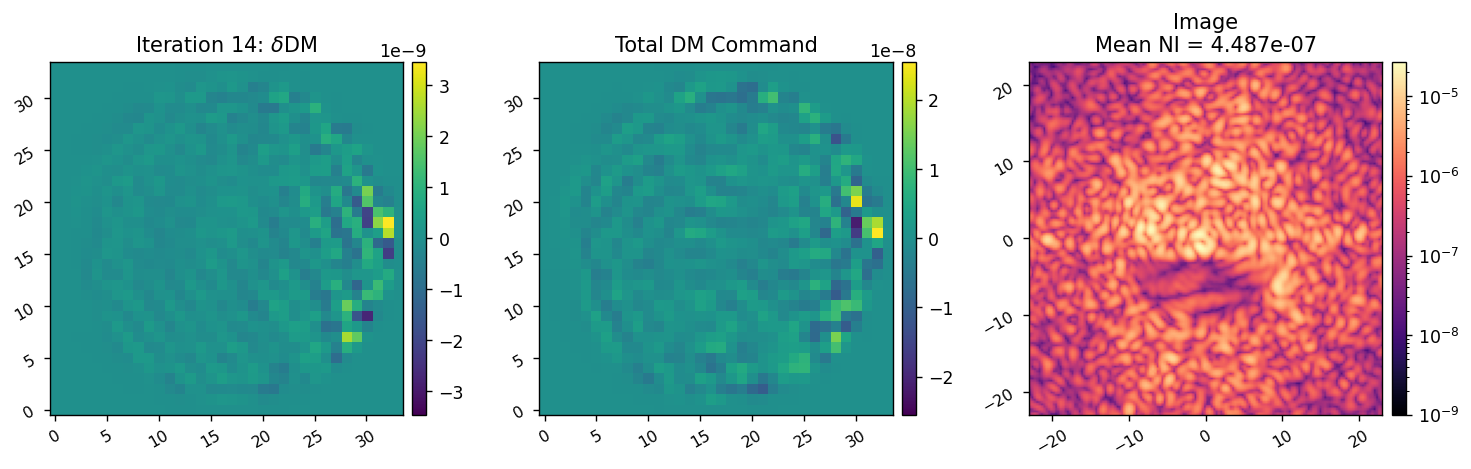

In [346]:
reload(scoobm)
reload(aefc)

I.NSCICAM = 20

bfgs_tol = 1e-2
bfgs_tol = 1e-3
# bfgs_tol = 1e-4
# bfgs_tol = 1e-5

bfgs_opts = {
    'disp':True,
    'maxiter':25,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

pwp_params = {
    'control_mask':control_mask, 
    'probes':fourier_probes,
    'probe_amp':2.5e-9,
    'probe_amp':1.5e-9,
    # 'probe_amp':1e-9,
    # 'probe_amp':0.75e-9,
    # 'probe_amp':0.5e-9,
    # 'probe_amp':0.3e-9,
    # 'probe_amp':0.2e-9,
    'wavelength':I.wavelength_c,
    'reg_cond':1e-2,
    'reg_cond':1e-3,
    # 'reg_cond':1e-4,
    # 'gain':2,
    'Ndms':1,
    # 'plot':True,
    'plot_est':True, 
}

data = aefc.run(
    I, 
    M, 
    scoobm.val_and_grad, 
    control_mask, 
    data,
    pwp_params=pwp_params,
    # Nitr=2, reg_cond=1e-1,
    # Nitr=2, reg_cond=1e-2,
    # Nitr=2, reg_cond=1e-3,
    # Nitr=2, reg_cond=1e-4,
    # Nitr=2, reg_cond=1e-5,
    # Nitr=2, reg_cond=1e-6,
    # Nitr=2, reg_cond=1e-7,
    Nitr=2, reg_cond=1e-8,
    # Nitr=2, reg_cond=1e-9,
    # Nitr=2, reg_cond=1e-10,
    bfgs_tol=bfgs_tol,
    bfgs_opts=bfgs_opts,
    gain=1,
    vmin=1e-9, 
)

In [201]:
utils.save_pickle(f'data/{today}_scoob_aefc_run_2.pkl', data)

Saved data to:  data/20250115_scoob_aefc_run.pkl


# Adjust attenuation for better SNR.

In [223]:
I.set_fib_atten(0, client)

Set the fiber attenuation to 0.0


2.4600343340103738e-08


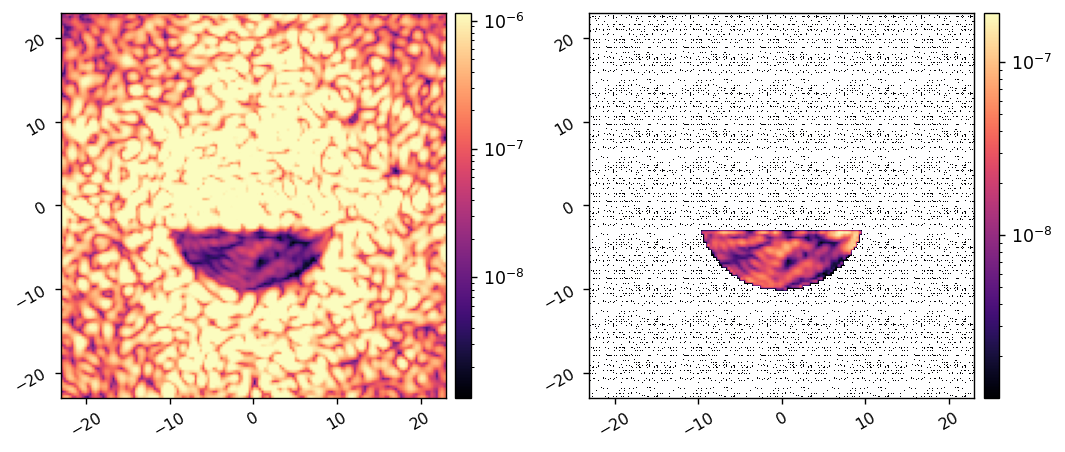

In [224]:
I.NSCICAM = 50
I.subtract_dark = True
I.return_ni = True

coro_im = I.snap()

print(xp.mean(coro_im[control_mask]))
imshow2(coro_im, control_mask * coro_im,
        lognorm=True, pxscl=I.psf_pixelscale_lamDc)

In [202]:
I.zero_dm()
I.set_zwo_exp_time(0.001, client0)
I.set_fib_atten(5, client)

Set the ZWO exposure time to 1.00e-03s
Set the fiber attenuation to 5.0


In [127]:
I.set_zwo_exp_time(0.001, client0)

Set the ZWO exposure time to 1.00e-03s


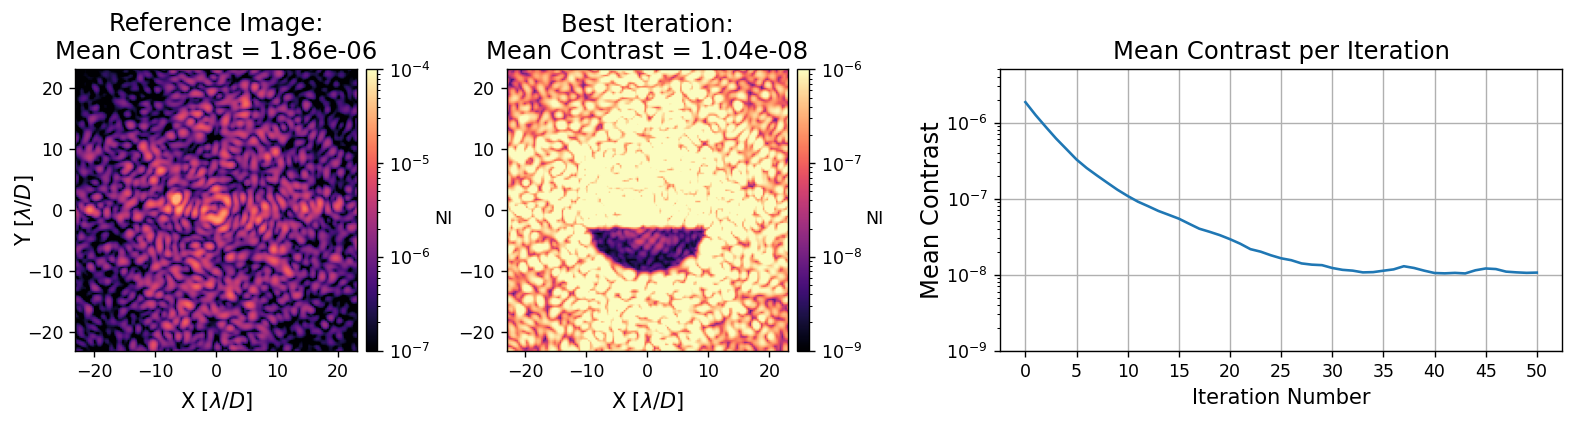

In [200]:
from adefc_vortex import imshows
reload(imshows)

imshows.plot_data_with_ref(
    data, 
    im1vmax=1e-4, im1vmin=1e-7, 
    im2vmax=1e-6, im2vmin=1e-9, 
    vmax=5e-6, vmin=1e-9, 
    xticks=np.arange(0, 50+1, 5),
    fname='../figs/scoob_mono_result.pdf',
)

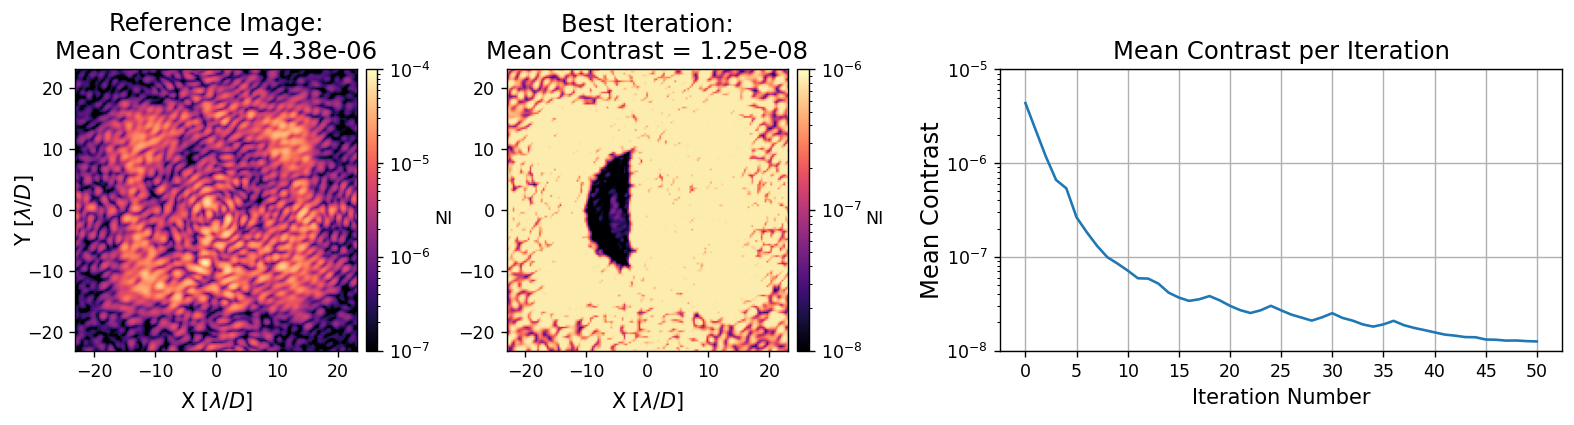

In [111]:
from adefc_vortex import imshows
reload(imshows)

imshows.plot_data_with_ref(
    data, 
    im1vmax=1e-4, im1vmin=1e-7, 
    im2vmax=1e-6, im2vmin=1e-8, 
    vmax=1e-5, vmin=1e-8, 
    xticks=np.arange(0, 50+1, 5),
    fname='../figs/scoob_mono_result.pdf',
)

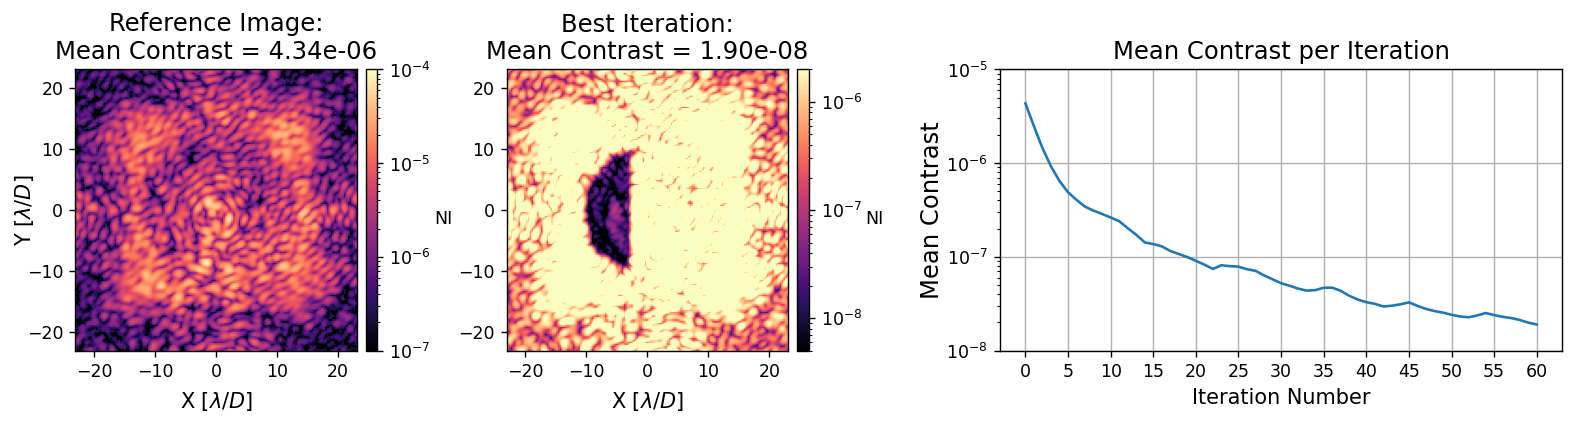

In [109]:
data = utils.load_pickle(f'data/{20241217}_scoob_aefc_run.pkl')

imshows.plot_data_with_ref(
    data, 
    im1vmax=1e-4, im1vmin=1e-7, 
    im2vmax=2e-6, im2vmin=5e-9, 
    vmax=1e-5, vmin=1e-8, 
    xticks=np.arange(0, 61, 5),
    fname='../figs/scoob_mono_result.pdf',
)

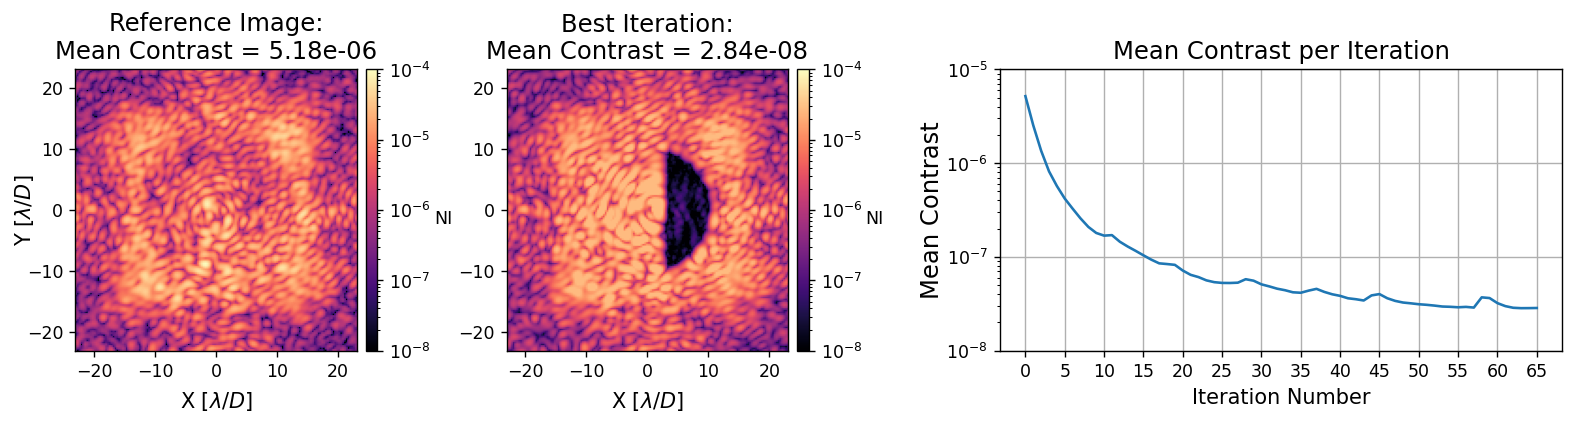

In [184]:
from adefc_vortex import imshows
reload(imshows)

imshows.plot_data_with_ref(
    data, 
    im1vmax=1e-4, im1vmin=1e-8, 
    im2vmax=1e-4, im2vmin=1e-8, 
    vmax=1e-5, vmin=1e-8, 
    xticks=np.arange(0, 66, 5),
)

In [10]:
M = scoobm.MODEL()
iwa = 3
owa = 10
rotation = 0
control_mask = utils.create_annular_focal_plane_mask(M.npsf, M.psf_pixelscale_lamDc, iwa, owa, edge=iwa, rotation=rotation)


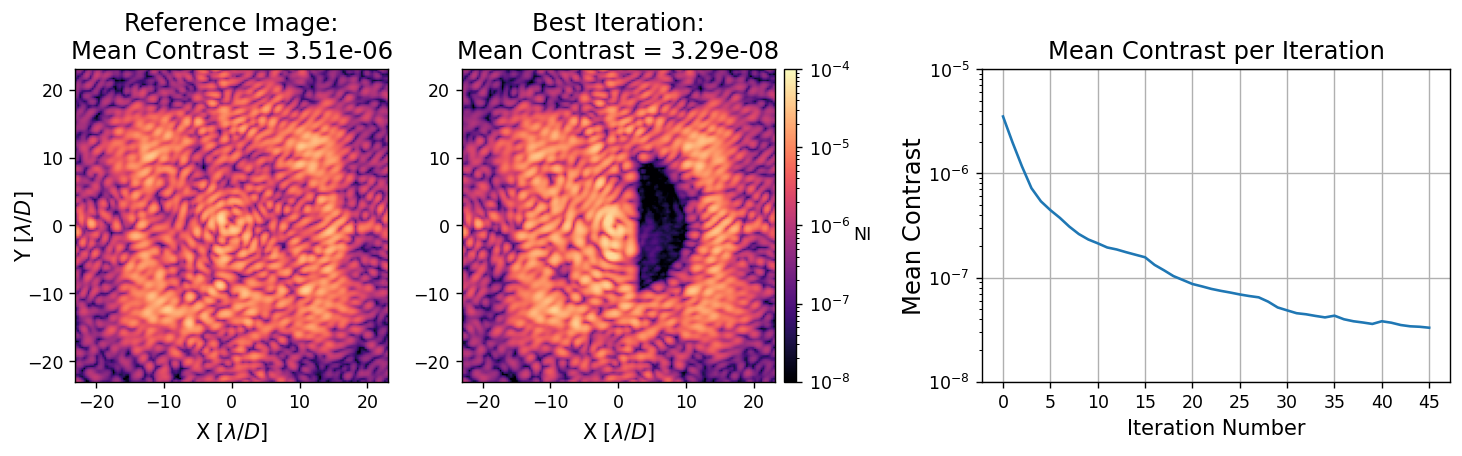

In [25]:
from adefc_vortex import imshows
reload(imshows)

date = 20241029
ref_im = utils.load_fits(f'data/{date}_ref_coro_im.fits')
ims = utils.load_fits(f'data/{date}_adefc_ims.fits')

data = {
    'images':xp.concatenate([xp.array([ref_im]), ims]),
    'control_mask': control_mask,
    'pixelscale':M.psf_pixelscale_lamDc,
}

imshows.plot_data(
    data, 
    imvmax=1e-4, imvmin=1e-8, 
    vmax=1e-5, vmin=1e-8, 
    xticks=np.arange(0, 46, 5),
)
